In [1]:
import sys
import numpy as np
np.random.seed(0)

# Main code for Concrete Dropout

In [2]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


# Evaluate Concrete Dropout on synthetic data

In [3]:
Ns = [10, 25, 50, 100, 1000, 10000]
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_val_size = 1000
nb_features = 1024
Q = 1
D = 1
K_test = 20
nb_reps = 3
batch_size = 20
l = 1e-4

In [4]:
def gen_data(N):
    sigma = 1e0  # ground truth
    X = np.random.randn(N, Q)
    w = 2.
    b = 8.
    Y = X.dot(w) + b + sigma * np.random.randn(N, D)
    return X, Y

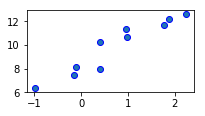

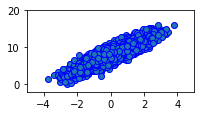

In [5]:
import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.savefig('data_10.pdf', bbox_inches='tight')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.xlim([-5, 5])
pylab.ylim([-2, 20])
pylab.savefig('data_10000.pdf', bbox_inches='tight')
pylab.show()

### Fit function:

In [6]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    mean = ConcreteDropout(Dense(D), weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(D), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :D]
        log_var = pred[:, D:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 5  # a loss for each Concrete Dropout layer
    hist = model.fit(X, Y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)
    loss = hist.history['loss'][-1]
    return model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [7]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, MC_samples):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    mean = MC_samples[:, :, :D]  # K x N x D
    logvar = MC_samples[:, :, D:]
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_true[None])**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi)
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_true)**2.)**0.5
    return pppp, rmse

### Plot function to make sure stuff makes sense:

In [8]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0], mean[:, 0], c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

#Run experiment

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


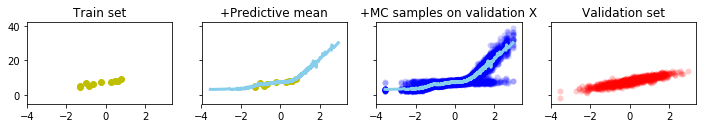

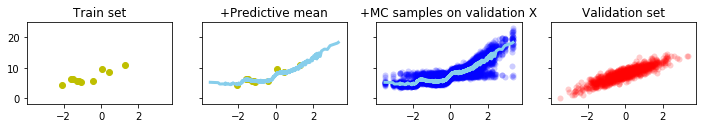

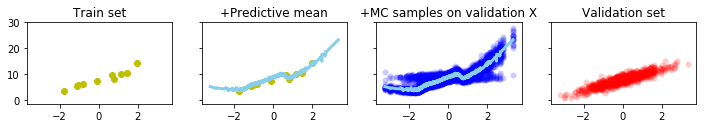

10 2000 - 1.8226084742 0.347263713816 [ 0.076855    0.40378514  0.4036386   0.40347314  0.40392923]  -  1.32133656351 1.09193542366


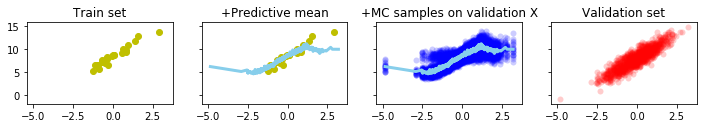

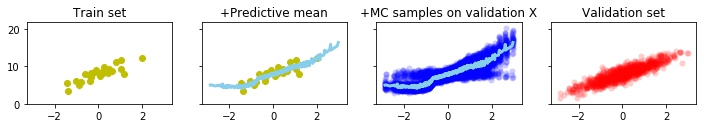

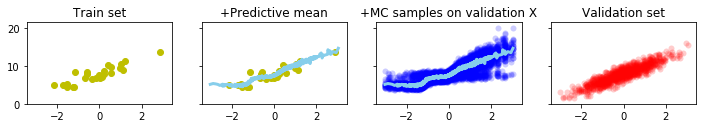

25 1000 - 1.17549462592 0.0491106697204 [ 0.06876557  0.40362921  0.40344572  0.40309581  0.40392563]  -  1.35654852785 0.819570441895


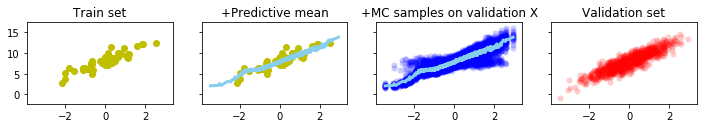

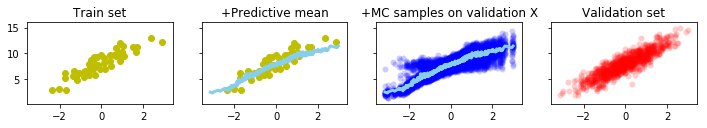

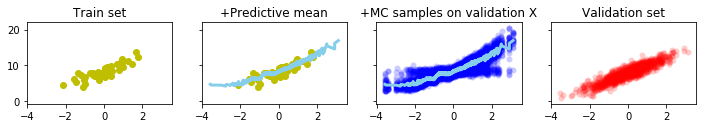

50 500 - 1.152001802 0.0546645034129 [ 0.07132343  0.32557228  0.32549378  0.32532749  0.32589889]  -  1.26965758649 0.745415424142


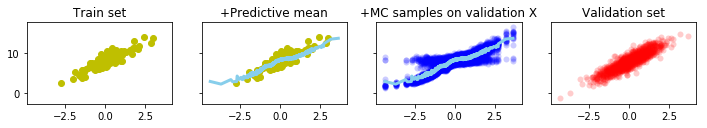

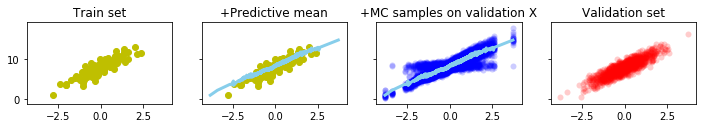

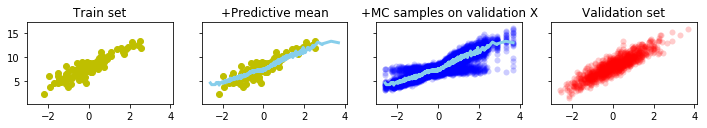

100 200 - 1.14467085788 0.0271470485769 [ 0.07868228  0.23599394  0.23589814  0.23577261  0.23628223]  -  1.24654124485 0.668062326223


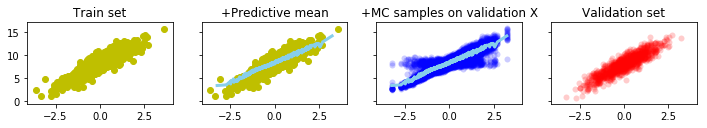

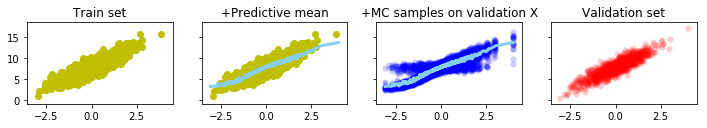

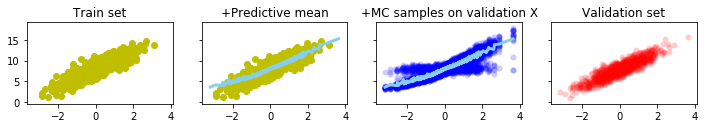

1000 20 - 1.06534282935 0.028514363992 [ 0.07469008  0.23062098  0.22492842  0.22430871  0.23339403]  -  1.32083792079 0.651976727698


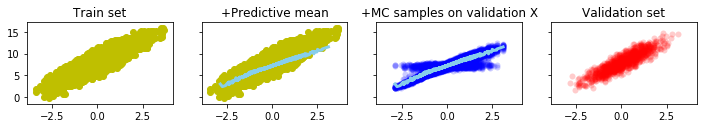

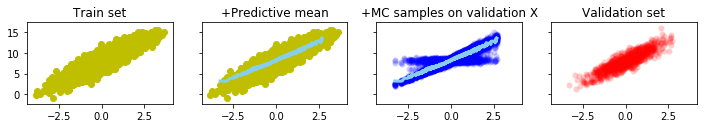

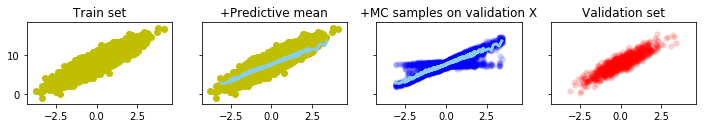

10000 2 - 1.20510557406 0.0890855681927 [ 0.07931601  0.13712122  0.12683423  0.11200676  0.16869354]  -  1.2288792592 0.54163583949


In [9]:
results = []
# get results for multiple N
for N, nb_epoch in zip(Ns, nb_epochs):
    # repeat exp multiple times
    rep_results = []
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        model, ELBO = fit_model(nb_epoch, X_train, Y_train)
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
        pppp, rmse = test(Y_val, MC_samples)  # per point predictive probability
        means = MC_samples[:, :, :D]  # K x N
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(MC_samples[:, :, D:], 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5
    sys.stdout.flush()
    results += [rep_results]

In [10]:
import pickle
with open('concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [11]:
# import pickle
# with open('concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [12]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_aleatoric_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
best_epistemic_uncertainty = np.array([[r[3] for r in result] for result in results]).T.squeeze()
print best_tests.mean(0)
print best_ps.mean(1)

[ 1.82260847  1.17549463  1.1520018   1.14467086  1.06534283  1.20510557]
[[ 0.076855    0.40378514  0.4036386   0.40347314  0.40392923]
 [ 0.06876557  0.40362921  0.40344572  0.40309581  0.40392563]
 [ 0.07132343  0.32557228  0.32549378  0.32532749  0.32589889]
 [ 0.07868228  0.23599394  0.23589814  0.23577261  0.23628223]
 [ 0.07469008  0.23062098  0.22492842  0.22430871  0.23339403]
 [ 0.07931601  0.13712122  0.12683423  0.11200676  0.16869354]]


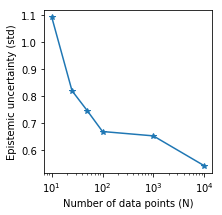

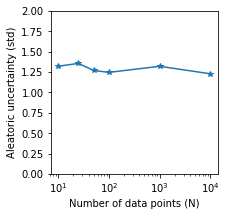

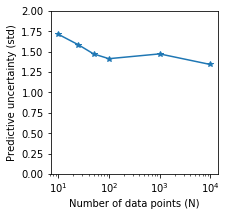

In [13]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_aleatoric_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Aleatoric uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('aleatoric.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(Ns, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

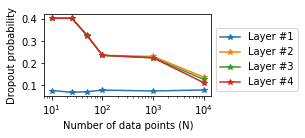

In [17]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(Ns, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()